## Image Classification of Album Cover Images

In [1]:
import numpy as np
import pandas as pd

import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchmetrics.classification import BinaryF1Score
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import os

!pip install -q torch-lr-finder
from torch_lr_finder import LRFinder

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Dataloaders and Datasets

In [2]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomPosterize(4, p = 0.25),
    transforms.ColorJitter(brightness = (0.15, 0.90)),
    transforms.RandomRotation(degrees = 15),
    transforms.ToTensor()
])

In [3]:
TRAIN_MERGED_PATH = "/kaggle/input/mumu-image-classification-album/mumu-images-classification/train"
TEST_MERGED_PATH = "/kaggle/input/mumu-image-classification-album/mumu-images-classification/test"

In [4]:
train_dataset = datasets.ImageFolder(TRAIN_MERGED_PATH, transform = transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)

test_dataset = datasets.ImageFolder(TEST_MERGED_PATH, transform = transforms.ToTensor())
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = True)

In [5]:
train_dataset[0][0].shape

torch.Size([3, 256, 256])

In [6]:
train_dataset.classes

['ai', 'human']

## Model

In [7]:
models.list_models(module=models)

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'googlenet',
 'inception_v3',
 'maxvit_t',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_128gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf',
 'regnet_y_8gf',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext101_64x4d',
 'resnext50_32x4d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'sh

In [8]:
class CreativeNet(nn.Module):
    def __init__(self, train_baseline_classifier = False, num_output_classes = 2, dropout_rate = 0.20):
        super().__init__()
        
        # Set instance variables
        self.train_baseline_classifier = train_baseline_classifier
        self.num_outuput_classes = num_output_classes
        self.dropout_rate = dropout_rate
        
        # Set the current device for tensor calculations
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Baseline: Shufflenet V2 X2
        self.baseline = models.shufflenet_v2_x2_0(weights = models.ShuffleNet_V2_X2_0_Weights.IMAGENET1K_V1)
        
        # Freeze the parameters of the base model (including but not limited to the last layers)
        for param in self.baseline.parameters():
            param.requires_grad = False
        
        if self.train_baseline_classifier:
            for param in self.baseline.classifier.parameters():
                param.requires_grad = True
                
        # Fully-connected block
        self.fc1 = nn.Linear(1000, 128)
        self.dropout1 = nn.Dropout(self.dropout_rate)
        self.fc2 = nn.Linear(128, 32)
        self.dropout2 = nn.Dropout(self.dropout_rate)
        self.fc3 = nn.Linear(32, self.num_outuput_classes)
        
    def forward(self, x):
        # Baseline
        x = x.to(self.device)
        x = self.baseline(x)
        
        # FC Block
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.leaky_relu(self.fc3(x))
        x = torch.sigmoid(x)
        return x

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

MODEL_ARGS = {
    "train_baseline_classifier" : False, 
    "num_output_classes" : len(train_dataset.classes),
    "dropout_rate" : 0.35
}

model = CreativeNet(**MODEL_ARGS).to(device)

Using device cuda


Downloading: "https://download.pytorch.org/models/shufflenetv2_x2_0-8be3c8ee.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x2_0-8be3c8ee.pth
100%|██████████| 28.4M/28.4M [00:00<00:00, 105MB/s] 


## Criterion and Optimiser

In [10]:
criterion = nn.CrossEntropyLoss()

  0%|          | 0/300 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.26E-02


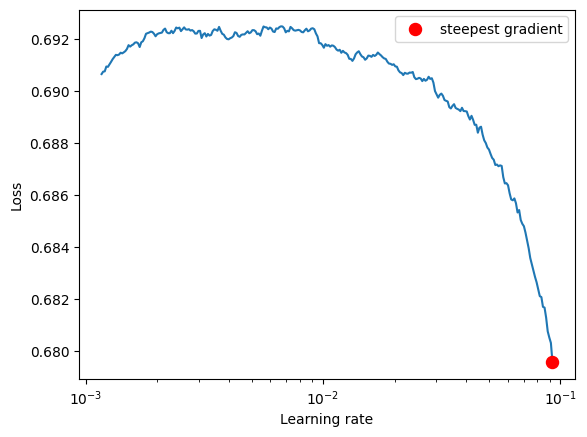

In [11]:
optimiser = optim.SGD(model.parameters(), lr = 0.001)
lr_finder = LRFinder(model, optimiser, criterion, device="cuda")
lr_finder.range_test(train_dataloader, end_lr=0.1, num_iter=300)

lr_finder.plot()
lr_finder.reset()

In [12]:
optimiser = optim.SGD(model.parameters(), lr = 9.26E-02)

## Metrics

In [13]:
metric = BinaryF1Score().to(device)

## Train and test the model

In [14]:
def train_test_loop(model, train_dataloader, test_dataloader, num_epochs = 100, save_prefix = "mumu_", verbose = False):
    # Save F1 scores and best model
    all_train_f1_scores = []
    all_test_f1_scores = []
    best_model = None
    candidate_f1_score = 0.0
    save_path = "fallback.pt"
    
    for epoch in tqdm(range(num_epochs)):
        # Training loop
        f1_scores = []
        model.train()
        for i, data in enumerate(train_dataloader, 0):
            # Load the inputs
            inputs, labels = data
            inputs = torch.Tensor(inputs).to(device)
            labels = torch.Tensor(labels).to(device)
                        
            # Forward + Backward + Optimise
            optimiser.zero_grad()
            outputs = model(inputs)
            outputs = torch.Tensor(outputs).to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimiser.step()
            
            # Training metrics calculation
            output_classes = torch.argmax(outputs, dim = 1)
            output_classes = torch.Tensor(output_classes).to(device)
            f1_score = metric(output_classes, labels)
            f1_scores.append(f1_score)
            
        # Update best scores and best model
        average_f1_score = (sum(f1_scores)/len(f1_scores))
        all_train_f1_scores.append(average_f1_score)
        if average_f1_score > candidate_f1_score:
            candidate_f1_score = average_f1_score
            average_f1_score_print = float(average_f1_score.cpu().detach())
            save_path = f"{save_prefix}_train_{str(average_f1_score_print).replace('.','_')}.pt"
            
        # Testing loop
        test_f1_scores = []
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(test_dataloader, 0):
                # Load the inputs
                inputs, labels = data
                inputs = torch.Tensor(inputs).to(device)
                labels = torch.Tensor(labels).to(device)

                # Forward
                outputs = model(inputs)
                outputs = torch.Tensor(outputs).to(device)
                output_classes = torch.argmax(outputs, dim = 1)
                output_classes = torch.Tensor(output_classes).to(device)
                
                # Testing metrics calculation
                f1_score = metric(output_classes, labels)
                test_f1_scores.append(f1_score)
            average_test_f1_score = (sum(test_f1_scores)/len(test_f1_scores))
            all_test_f1_scores.append(average_test_f1_score)
            
        
        # Verbose output if warranted
        if verbose:
            current_train_f1_score = all_train_f1_scores[-1]
            current_test_f1_score = all_test_f1_scores[-1]
            print(f"Train F1: {current_train_f1_score}, Test F1: {current_test_f1_score}")
        
    # Save best model at the end of the training loop
    torch.save(model.state_dict(), save_path)

In [15]:
TRAIN_ARGS = {
    "model" : model,
    "train_dataloader" : train_dataloader,
    "test_dataloader" : test_dataloader,
    "num_epochs" : 50,
    "save_prefix" : "mumu_shufflenet_v2x2",
    "verbose" : True
}

In [16]:
train_test_loop(**TRAIN_ARGS)

  2%|▏         | 1/50 [00:03<02:32,  3.10s/it]

Train F1: 0.34727466106414795, Test F1: 0.21089762449264526


  4%|▍         | 2/50 [00:06<02:32,  3.17s/it]

Train F1: 0.44904661178588867, Test F1: 0.2863147258758545


  6%|▌         | 3/50 [00:09<02:24,  3.08s/it]

Train F1: 0.549481213092804, Test F1: 0.32466253638267517


  8%|▊         | 4/50 [00:12<02:19,  3.04s/it]

Train F1: 0.5710462927818298, Test F1: 0.5062410831451416


 10%|█         | 5/50 [00:15<02:14,  2.98s/it]

Train F1: 0.6185270547866821, Test F1: 0.6633040904998779


 12%|█▏        | 6/50 [00:18<02:10,  2.96s/it]

Train F1: 0.6369808912277222, Test F1: 0.730977475643158


 14%|█▍        | 7/50 [00:21<02:08,  2.99s/it]

Train F1: 0.6986756324768066, Test F1: 0.7874376177787781


 16%|█▌        | 8/50 [00:23<02:03,  2.94s/it]

Train F1: 0.7057039737701416, Test F1: 0.8034877181053162


 18%|█▊        | 9/50 [00:26<01:59,  2.91s/it]

Train F1: 0.7716292142868042, Test F1: 0.7989475727081299


 20%|██        | 10/50 [00:29<01:55,  2.89s/it]

Train F1: 0.781395435333252, Test F1: 0.7984166145324707


 22%|██▏       | 11/50 [00:32<01:51,  2.86s/it]

Train F1: 0.7964804172515869, Test F1: 0.7776913046836853


 24%|██▍       | 12/50 [00:35<01:49,  2.87s/it]

Train F1: 0.8301716446876526, Test F1: 0.7882235050201416


 26%|██▌       | 13/50 [00:38<01:45,  2.86s/it]

Train F1: 0.8097059726715088, Test F1: 0.7983483076095581


 28%|██▊       | 14/50 [00:40<01:42,  2.85s/it]

Train F1: 0.8354599475860596, Test F1: 0.7968933582305908


 30%|███       | 15/50 [00:43<01:39,  2.85s/it]

Train F1: 0.8480172753334045, Test F1: 0.7791397571563721


 32%|███▏      | 16/50 [00:46<01:37,  2.86s/it]

Train F1: 0.8635537028312683, Test F1: 0.7989798784255981


 34%|███▍      | 17/50 [00:49<01:34,  2.88s/it]

Train F1: 0.8622328639030457, Test F1: 0.8060874938964844


 36%|███▌      | 18/50 [00:52<01:33,  2.92s/it]

Train F1: 0.8559827208518982, Test F1: 0.7938019633293152


 38%|███▊      | 19/50 [00:55<01:30,  2.92s/it]

Train F1: 0.8697991967201233, Test F1: 0.8001430034637451


 40%|████      | 20/50 [00:58<01:27,  2.92s/it]

Train F1: 0.858171284198761, Test F1: 0.7729803919792175


 42%|████▏     | 21/50 [01:01<01:24,  2.90s/it]

Train F1: 0.884624719619751, Test F1: 0.8030472993850708


 44%|████▍     | 22/50 [01:04<01:21,  2.93s/it]

Train F1: 0.8828203678131104, Test F1: 0.804109513759613


 46%|████▌     | 23/50 [01:07<01:19,  2.93s/it]

Train F1: 0.8901110887527466, Test F1: 0.7962180972099304


 48%|████▊     | 24/50 [01:10<01:15,  2.92s/it]

Train F1: 0.8731271624565125, Test F1: 0.7881696224212646


 50%|█████     | 25/50 [01:13<01:12,  2.92s/it]

Train F1: 0.9073793888092041, Test F1: 0.8053917288780212


 52%|█████▏    | 26/50 [01:16<01:10,  2.93s/it]

Train F1: 0.9130374193191528, Test F1: 0.7899073362350464


 54%|█████▍    | 27/50 [01:18<01:06,  2.90s/it]

Train F1: 0.8831408023834229, Test F1: 0.8108575344085693


 56%|█████▌    | 28/50 [01:21<01:03,  2.90s/it]

Train F1: 0.9301386475563049, Test F1: 0.8065381050109863


 58%|█████▊    | 29/50 [01:24<01:01,  2.95s/it]

Train F1: 0.9149654507637024, Test F1: 0.7835042476654053


 60%|██████    | 30/50 [01:27<00:58,  2.94s/it]

Train F1: 0.915676474571228, Test F1: 0.8064365386962891


 62%|██████▏   | 31/50 [01:30<00:55,  2.93s/it]

Train F1: 0.9205193519592285, Test F1: 0.8242623805999756


 64%|██████▍   | 32/50 [01:33<00:52,  2.92s/it]

Train F1: 0.9287850260734558, Test F1: 0.8157931566238403


 66%|██████▌   | 33/50 [01:36<00:49,  2.91s/it]

Train F1: 0.9209309220314026, Test F1: 0.8110991716384888


 68%|██████▊   | 34/50 [01:39<00:46,  2.88s/it]

Train F1: 0.9326699376106262, Test F1: 0.7995798587799072


 70%|███████   | 35/50 [01:42<00:43,  2.87s/it]

Train F1: 0.93110591173172, Test F1: 0.7921510934829712


 72%|███████▏  | 36/50 [01:45<00:40,  2.90s/it]

Train F1: 0.9356108903884888, Test F1: 0.8032569289207458


 74%|███████▍  | 37/50 [01:48<00:37,  2.92s/it]

Train F1: 0.9367426633834839, Test F1: 0.8297983407974243


 76%|███████▌  | 38/50 [01:50<00:34,  2.89s/it]

Train F1: 0.9199014902114868, Test F1: 0.8165452480316162


 78%|███████▊  | 39/50 [01:53<00:31,  2.91s/it]

Train F1: 0.9196805357933044, Test F1: 0.8265566825866699


 80%|████████  | 40/50 [01:56<00:29,  2.95s/it]

Train F1: 0.93431156873703, Test F1: 0.8148951530456543


 82%|████████▏ | 41/50 [01:59<00:26,  2.92s/it]

Train F1: 0.930779218673706, Test F1: 0.8031095266342163


 84%|████████▍ | 42/50 [02:02<00:23,  2.98s/it]

Train F1: 0.9390357732772827, Test F1: 0.8202273845672607


 86%|████████▌ | 43/50 [02:05<00:20,  2.98s/it]

Train F1: 0.9392049312591553, Test F1: 0.820309042930603


 88%|████████▊ | 44/50 [02:08<00:17,  2.95s/it]

Train F1: 0.9526976943016052, Test F1: 0.8195516467094421


 90%|█████████ | 45/50 [02:11<00:14,  2.93s/it]

Train F1: 0.9500188827514648, Test F1: 0.8324298858642578


 92%|█████████▏| 46/50 [02:14<00:11,  2.90s/it]

Train F1: 0.9375083446502686, Test F1: 0.8313247561454773


 94%|█████████▍| 47/50 [02:17<00:08,  2.90s/it]

Train F1: 0.9551687836647034, Test F1: 0.8388862013816833


 96%|█████████▌| 48/50 [02:20<00:05,  2.89s/it]

Train F1: 0.948387086391449, Test F1: 0.8341983556747437


 98%|█████████▊| 49/50 [02:22<00:02,  2.87s/it]

Train F1: 0.9510796070098877, Test F1: 0.8488583564758301


100%|██████████| 50/50 [02:25<00:00,  2.92s/it]

Train F1: 0.9365931153297424, Test F1: 0.8403042554855347
